All data was collected on a Beckman-Coulter Z2 Coulter Counter

In [1]:
using Bootstrap
using CategoricalArrays
using Coulter
using CSV
using DataFrames
using DataStructures
using Dates
using Measures
using Plots
using Plots: px
using StatsBase
using StatsPlots
using Measurements
using Statistics
using Unitful
using ZipFile

rootfolder = normpath(joinpath(@__DIR__, "..", "..", "..", "..")); #hide

Load utility functions

In [2]:
include(joinpath(rootfolder, "figures", "utils.jl"))

Load dataset details

In [3]:
meta = CSV.File(joinpath(rootfolder, "data", "coulter_datasets.csv")) |> DataFrame;

## Load all data from compressed archive

Tweaked version of
[`Coulter.load_folder`](https://github.com/tlnagy/Coulter.jl/blob/501f735f28c813f7c525cbe988041a82cd5ed4e0/src/utils.jl#L34-L56)
to handle compressed archives

In [4]:
function load_compressed_folder(archive, datapath)
    # get the compressed files that relate to this dataset
    compressed = filter(x->occursin(datapath, x.name), archive.files)
    filter!(x->x.compressedsize > 0, compressed)

    runs = DefaultDict{String, Array{Coulter.CoulterCounterRun}}([])

    for run in compressed
        sample = split(basename(run.name), "_")[1]
        # load Coulter data from the compressed stream
        seekstart(run)
        push!(runs[sample], Coulter.loadZ2(run, run.name, String(sample)))
    end

    # fix ordering of runs by resort the datasets based on the actual embedded
    # time
    for (_, samples) in runs
        sort!(samples, by=i->i.timepoint)
    end
    runs
end

archive = ZipFile.Reader(joinpath(rootfolder, "data", "coulter_data.zip"))

runidx = 0
rawdata = vcat(map(pairs(groupby(meta, :DataPath))) do (key, metadf)
    runs = load_compressed_folder(archive, key.DataPath)
    vcat(map(eachrow(metadf)) do row # for each row in the meta table load the runs as new rows each
        global runidx += 1
        DataFrame(:runidx => runidx, pairs(row)..., :CoulterData => runs[row.SampleCode])
    end...)
end...);

## Add relative time

In [5]:
"""
    normtime(t, o)

Normalize time `t` to the 1 minute origin time `o`
"""
normtime = (t, o) -> uconvert(u"s", Quantity(t.timepoint - o.timepoint)*1.0 + 60u"s")

transform!(groupby(rawdata, :runidx),
    :CoulterData => (seq->[normtime(run, seq[4]) for run in seq]) => :reltime).reltime;

## Remove timepoint with blockage

In [6]:
blocked = subset(rawdata, :Volunteer => ByRow(==("V20")),
                :Sample => ByRow(==("WT")),
                :reltime => ByRow(≈(8u"minute", rtol = 0.05)), view = true) # clog time

blocked.CoulterData .= missing;

remove V4 Duvelisib data since it was at 100nM instead of 1uM

In [7]:
filter!(x->(x.Sample != "Duvelisib") || (x.Volunteer != "V4"), rawdata);

## Apply Summary Statistics
Here we compute the 95% confidence interval using bootstrapping

In [8]:
function apply(func, r::CoulterCounterRun)
    binlims = r.binlims
    binvols = [(binlims[i] + binlims[i+1])/2 ± (binlims[i + 1] - binlims[i])/2 for i in 1:length(binlims)-1]
    measurements = filter(x->x > 200, Coulter.repvec(binvols, convert(Vector{Int}, r.binheights)))
    m, l, u = confint(bootstrap(func, measurements, BasicSampling(1_000)), BasicConfInt(0.95))[1]
    NamedTuple{tuple([Symbol(string(func) * "_" * x) for x in ["m", "l", "u"]]...)}((m,l,u))
end

function apply(func, ::Missing)
    NamedTuple{tuple([Symbol(string(func) * "_" * x) for x in ["m", "l", "u"]]...)}((missing, missing, missing))
end

transform!(rawdata,
    :CoulterData => ByRow(x-> apply(median, x)) => AsTable);

dropmissing!(rawdata);

## Plot raw volumes of each condition

qt.qpa.xcb: could not connect to display 
qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "" even though it was found.
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: linuxfb, minimal, offscreen, vnc, xcb.

Aborted (core dumped)
connect: Connection refused
GKS: can't connect to GKS socket application

GKS: Open failed in routine OPEN_WS
GKS: GKS not in proper state. GKS must be either in the state WSOP or WSAC in routine ACTIVATE_WS


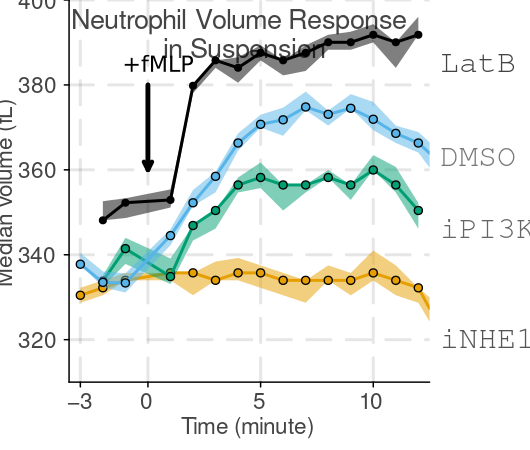

In [9]:
rawdata.roundtime = round.(u"minute", rawdata.reltime);

combo = sort(combine(groupby(rawdata, [:roundtime, :Sample]),
        :median_m => mean, :median_l => mean, :median_u => mean, :median_m => length),
        :roundtime)

filter!(x->x.Sample in ["WT", "BIX", "Duvelisib", "LatB"], combo)
combo.Sample = replace.(combo.Sample, "WT" => "DMSO", "BIX" => "iNHE1", "Duvelisib" => "Duvelisib")
combo.Sample = categorical(combo.Sample, levels = ["LatB", "iNHE1", "DIDS", "Duvelisib", "DMSO"])
p = @df combo plot(:roundtime, Measurements.value.(:median_m_mean),
    ribbon = (Measurements.value.(:median_m_mean .- :median_l_mean),
    Measurements.value.(:median_u_mean .- :median_m_mean)), group = :Sample,
    leg = false, linewidth = 2, ylabel = "Median volume (fL)", xlabel = "Time",
    c = [5 2 4 1],
    m = 3, topmargin = -3mm, margin = 25px,
    framestyle = :axes, xticks = [-3, 0, 5, 10],
    title = "Neutrophil Volume Response\nin Suspension",
    xlim = (-3.5u"minute", 12.5u"minute"), ylim = (310, 400), size = (530, 450))

plot!([0, 0],[380,360],arrow=true,color=:black,linewidth=3,label="", rightmargin = 15mm)
annotate!(2, 385, text("+fMLP", :black, :right, 10))
annotate!(13, 320, text("iNHE1", okabe_ito[2], :left, :bold, 11))
annotate!(13, 363, text("DMSO", okabe_ito[1], :left, :bold, 11))
annotate!(13, 385, text("LatB", okabe_ito[5], :left, :bold, 11))
annotate!(13, 346, text("iPI3Kγ", okabe_ito[4], :left, :bold, 11))
savefig(p, "assets/coulter_response_kos.svg") #hide
p

## Plot normalized volumes of hits
Here we normalize to the pre-stimulation volumes

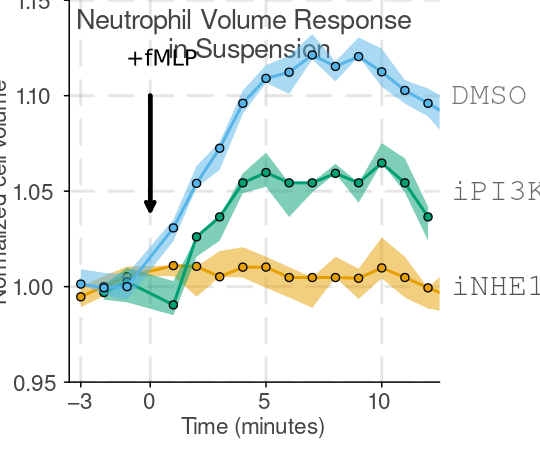

In [10]:
normed = combine(groupby(rawdata, [:Date, :Sample]),
    [:median_m, :roundtime] => ((m,t) -> m ./ mean(m[t .< 0u"minute"])) => :normed_m,
    [:median_m, :median_u, :roundtime] => ((m1,m2,t) -> m2 ./ mean(m1[t .< 0u"minute"])) => :normed_u,
    [:median_m, :median_l, :roundtime] => ((m1,m2,t) -> m2 ./ mean(m1[t .< 0u"minute"])) => :normed_l,
    :roundtime
)

combo = sort(combine(groupby(normed, [:roundtime, :Sample]),
        :normed_m => mean, :normed_l => mean, :normed_u => mean, :normed_m => length),
        :roundtime)

function normplot(combo, colors)
    @df combo plot(:roundtime, Measurements.value.(:normed_m_mean),
                   ribbon = (Measurements.value.(:normed_m_mean .- :normed_l_mean),
                   Measurements.value.(:normed_u_mean .- :normed_m_mean)), group = :Sample,
                   leg = false, linewidth = 2, ylabel = "Normalized cell volume", xlabel = P"Time (minutes)",
                   c = colors,
                   m = 3, topmargin = -3mm, rightmargin = 15mm,
                   framestyle = :axes, xticks = [-3, 0, 5, 10],
                   title = "Neutrophil Volume Response\nin Suspension",
                   xlim = (-3.5, 12.5), ylim = (0.95, 1.1501),
                   tick_direction = :out,
                   size = (490, 400)
    )
    plot!([0, 0],[1.1,1.04],arrow=true,color=:black,linewidth=3,label="", rightmargin = 15mm)
    annotate!(2, 1.12, text("+fMLP", :black, :right, 10))
end

combo.Sample = replace.(combo.Sample, "WT" => "DMSO", "BIX" => "iNHE1", "Duvelisib" => "Duvelisib")
combo.Sample = categorical(combo.Sample, levels = ["LatB", "iNHE1", "DIDS", "Duvelisib", "DMSO"])

p = normplot(filter(x->x.Sample in ["DMSO", "iNHE1", "Duvelisib"], combo), [2 4 1])

annotate!(13, 1.00, text("iNHE1", okabe_ito[2], :left, :bold, 11))
annotate!(13, 1.10, text("DMSO", okabe_ito[1], :left, :bold, 11))
annotate!(13, 1.05, text("iPI3Kγ", okabe_ito[4], :left, :bold, 11), margin = 25px, size = (540, 450))
p

## Plot normalized volume for Latrunculin condition

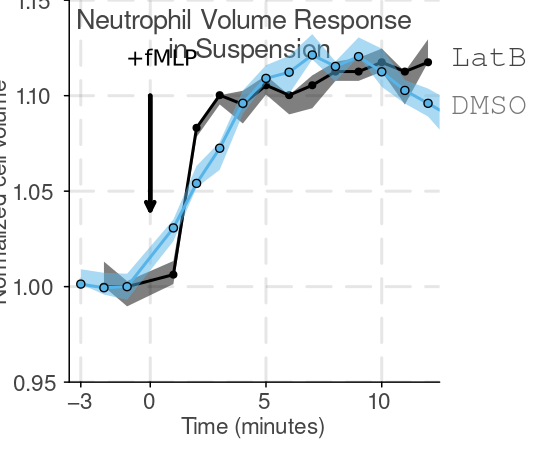

In [11]:
p2 = normplot(filter(x->x.Sample in ["DMSO", "LatB"], combo), [5 1])
annotate!(13, 1.095, text("DMSO", okabe_ito[1], :left, :bold, 11))
annotate!(13, 1.12, text("LatB", okabe_ito[5], :left, :bold, 11), margin = 25px, size = (540, 450))
p2

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*